In [ ]:
#default_exp core.vase_model

In [ ]:
#export
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from cmaes import CMA
import os
import numpy as np

from vase.core.models import FCEncoder, FCDecoder, Encoder, Decoder, EnvironmentInference
from vase.core.utils import rec_likelihood, disable_gradient, kl_div_stdnorm, euclidean, show_batch
from vase.config import DATA_PATH, LOG_PATH

In [ ]:
#hide
from vase.core.datasets.moving_mnist import CommonMNIST, CommonFashionMNIST, MovingMNIST, MovingFashionMNIST, FixedMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
batch_size = 64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

# Vase Model

In [ ]:
#export
class VASE(nn.Module):
    def __init__(self, 
        encoder_type: type,
        decoder_type: type,
        latents: int,
        final_size: int,
        max_envs: int,
        env_optim: type, 
        env_lr: float,
        replay_batch_size: int,
        tau: int,
        kappa: float,  
        lam: float,
        lam_1: float,
        lam_2: float, 
        Tau: float,
        used_epochs: int,
        used_delta: float,
        used_sigma: float,
        device: str
    ):
        super().__init__()
        self.latents = latents
        self.max_envs = max_envs
        self.final_size = final_size
        self.device = device
        self.encoder = encoder_type(self.latents)
        self.decoder = decoder_type(self.latents, self.max_envs)
        self.old_encoder = encoder_type(self.latents)
        self.old_decoder = decoder_type(self.latents, self.max_envs)
        self.copy_and_freeze()
        self.encoder.to(self.device), self.decoder.to(self.device), self.old_encoder.to(self.device), self.old_decoder.to(self.device)
        self.steps = 0
        self.tau = tau
        self.replay_batch_size = replay_batch_size
        self.env_net = EnvironmentInference(self.max_envs, self.final_size)
        self.m = 0
        self.env_optim = env_optim(params=self.env_net.parameters(), lr=env_lr)
        self.env_loss = nn.CrossEntropyLoss()
        self.rec_losses = []
        self.kappa = kappa
        self.masks = []
        self.lam = lam
        self.lam_1 = lam_1
        self.lam_2 = lam_2
        self.Tau = Tau
        self.used_epochs = used_epochs
        self.used_delta = used_delta
        self.used_sigma = used_sigma

    def forward(self, x):
        batch_size = x.shape[0]
        self.steps += 1

        mu, logvar, final = self.encoder(x)
        s_hat, env_logits = self.get_likely_env(final)
        if self.training:
            z = self.reparam(mu, logvar)
        else:
            z = mu
        
        a, alphas = self.get_mask(z)
        masked_z, masked_mu, masked_logvar = self.apply_mask(z, a, mu, logvar)

        s = self.infer_env(x, batch_size, masked_z, s_hat, a)
        
        rec_x = self.decoder(masked_z, self.int_to_vec(s, batch_size))
        
        if not self.training:
            return rec_x
        
        x_halu, s_halu = self.sample_old()
        with torch.no_grad():
            mu_halu_old, logvar_halu_old, final_halu_old = self.old_encoder(x_halu)
            z_halu_old = self.reparam(mu_halu_old, logvar_halu_old)
            a_halu_old = torch.stack([self.masks[s] for s in s_halu.tolist()])
            masked_z_halu_old, masked_mu_halu_old, masked_logvar_halu_old = self.apply_mask(z_halu_old, a_halu_old, mu_halu_old, logvar_halu_old)
        
        mu_halu, logvar_halu, final_halu = self.encoder(x_halu)
        z_halu = self.reparam(mu_halu, logvar_halu)
        a_halu, alphas_halu = self.get_mask(z_halu)
        masked_z_halu, masked_mu_halu, masked_logvar_halu = self.apply_mask(z_halu, a_halu, mu_halu, logvar_halu)
        rec_x_halo = self.decoder(masked_z_halu, s_halu)

        self.train_env_network(env_logits, s, final_halu_old, s_halu)

        if self.tau and self.steps > self.tau:
            self.copy_and_freeze()

        return rec_x, masked_mu, masked_logvar, x_halu, masked_z_halu_old, rec_x_halo, masked_z_halu

    def get_mask(self, z):
        std, mean = torch.std_mean(z, dim=0)
        std = std[:,None]
        mean = mean[:, None]
        logvar = torch.log(std.pow(2))
        alphas = kl_div_stdnorm(mean, logvar)
        alphas[alphas < self.lam_1] = 0
        alphas[alphas > self.lam_2] = 1
        a = alphas < self.lam
        return a, alphas
    
    def get_likely_env(self, final):
        env_logits = self.env_net(final)
        avg_env_logits = torch.mean(env_logits, dim=0)
        return torch.argmax(avg_env_logits), env_logits
    
    def reparam(self, mu, logvar):
        eps = torch.randn(logvar.shape).to(self.device)
        std = (0.5 * logvar).exp()
        return mu + std * eps
    
    def infer_env(self, x, batch_size, masked_z, s_hat, a):
        with torch.no_grad():
            rec_x = self.decoder(masked_z, self.int_to_vec(s_hat, batch_size))
        rec_loss = torch.mean(rec_likelihood(x, rec_x))
        
        if self.m == 0:
            self.init_env(rec_loss, a)
            return 0
        
        if self.m == self.max_envs - 1:
            self.update_env(rec_loss, a, self.m)
            return self.m
        
        if rec_loss > self.kappa * self.rec_losses[s_hat]:
            self.m+=1
            self.init_env(rec_x, a)
            return self.m
        
        if a != self.masks[s_hat]:
            u = self.get_used_mask(s_hat) 
            if a * u != self.masks[s_hat] * u:
              self.m+=1
              self.init_env(rec_x, a)
              return self.m

        self.update_env(rec_loss, a, s_hat)
        return s_hat 
        
    def init_env(self, rec_x, a):
        if self.tau is None:
            self.copy_and_freeze()
        self.rec_losses.append(rec_x)
        self.masks.append(a)
    
    def update_env(self, rec_loss, a, s):
        self.rec_losses[s] = rec_loss
        self.masks[s] = a
    
    def get_used_mask(self, x, batch_size, z, s_hat):
        optimizer = CMA(mean=np.zeros(self.latents), sigma=self.used_sigma)
        s_vec = self.int_to_vec(s_hat, batch_size)
        for generation in range(self.used_epochs):
            solutions = []
            for _ in range(optimizer.population_size):
                sigma_a = optimizer.ask()
                with torch.no_grad():
                    sigma_t = torch.tensor(x, dtype=torch.float)
                    sigma_t = torch.abs(sigma_t)
                    eps = torch.randn(sigma_t.shape[0]) * sigma_t
                    z_e = (1-self.used_delta) * z + (self.used_delta + eps)
                    rec_x = self.decoder(z_e, s_vec)
                    rec_loss = torch.mean(rec_likelihood(x, rec_x))
                    sum_sigma = torch.sum(sigma_t)
                    loss = rec_loss - sum_sigma
                value = loss.detach().numpy()
                solutions.append((sigma_a, value))
            optimizer.tell(solutions)
        sigma_p_a = sorted(solutions, key=lambda pair: pair[1], reverse=True)[0][0]
        sigma_p_t = torch.tensor(sigma_p_a, dtype=torch.float).abs()
        return sigma_p_t < self.Tau

    
    def int_to_vec(self, i, size):
        return torch.ones([size], dtype=torch.int64) * i
    
    def apply_mask(self, z, a, mu, logvar):
        #TODO: verify it broadcasts correctly in both cases
        std_norm = torch.randn(z.shape)
        masked_z = a * z + (~a) * std_norm # "reparam" trick again
        masked_mu = mu * a
        masked_logvar = logvar * a
        return masked_z, masked_mu, masked_logvar
    
    def copy_model(self, old_model, cur_model):
        old_model.load_state_dict(cur_model.state_dict())
    
    def freeze_model(self, model):
        disable_gradient(model)
    
    def copy_and_freeze(self):
        self.copy_model(self.old_encoder, self.encoder)
        self.freeze_model(self.old_encoder)
        self.copy_model(self.old_decoder, self.decoder)
        self.freeze_model(self.old_decoder)
    
    def train_env_network(self, env_logits, s, final_halu_old, s_halu):
        final_halu_old = final_halu_old[s != s_halu]
        s_halu = s_halu[s != s_halu]
        self.env_optim.zero_grad()
        cur_loss = self.env_loss(env_logits, self.int_to_vec(s, env_logits.shape[0])) #don't know if dims work here
        if len(s_halu) > 0:
            env_logits_halu = self.env_net(final_halu_old)
            replay_loss = self.env_loss(env_logits_halu, s_halu)
        else: 
            replay_loss = 0
        loss = cur_loss + replay_loss
        loss.backward(retain_graph=True)
        self.env_optim.step()
    
    def sample_old(self):
        s = torch.randint(0, self.m+1, (self.replay_batch_size,))
        z = torch.randn([self.replay_batch_size, self.latents])
        with torch.no_grad():
            halu_x = self.old_decoder(z, s)
        return halu_x, s

In [ ]:
latents=8
final_size=50
max_envs=7
env_optim=torch.optim.Adam
env_lr=6e-4
replay_batch_size=64
tau=2500
kappa=1.5
lam=1.5
lam_1=0.01
lam_2=3
Tau=None
used_epochs=50 
used_delta=.95
used_sigma = 1.3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vase = VASE(FCEncoder, FCDecoder, latents, final_size, max_envs, env_optim, env_lr, replay_batch_size, tau, kappa, lam, lam_1, lam_2, Tau, used_epochs, used_delta, used_sigma, device)

In [ ]:
epochs=10
lr=6e-4
gamma=4
C=0
alpha=1
beta=1
optimizer = torch.optim.Adam(params=vase.parameters(), lr=lr)
name = "vase" + dt.datetime.now().strftime('-%Y-%m-%d-%H-%M-%S')
writer = SummaryWriter(os.path.join(LOG_PATH, name))


In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, in sf_loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_x, masked_mu, masked_logvar, x_halu, masked_z_halu_old, rec_x_halo, masked_z_halu = vase(X)

        rec_loss = torch.mean(rec_likelihood(X, rec_x))
        kl_loss = gamma * torch.mean(torch.square(kl_div_stdnorm(masked_mu, masked_logvar)-C)) #NOTE: is this element wise or summed
        mdl_loss = rec_loss + kl_loss

        e_prox_loss = alpha * torch.mean(euclidean(masked_z_halu, masked_z_halu_old))
        d_prox_loss = beta * torch.mean(rec_likelihood(x_halu, rec_x_halo)) #NOTE: not sure if this order is correct
        dream_loss = e_prox_loss + d_prox_loss

        loss = mdl_loss + dream_loss

        loss.backward(retain_graph=True)
        optimizer.step()

        writer.add_scalar("train/loss", loss, vase.steps)
        writer.add_scalar("train/rec_loss", rec_loss, vase.steps)
        writer.add_scalar("train/kl_loss", kl_loss, vase.steps)
        writer.add_scalar("train/e_prox_loss", e_prox_loss, vase.steps)
        writer.add_scalar("train/d_prox_loss", d_prox_loss, vase.steps)
        writer.add_scalar("train/num_envs", vase.m+1, vase.steps)
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

epoch: 0, loss=13563.9384765625, rec_loss=5284.978515625, total_div_loss=184.65762329101562
epoch: 1, loss=12920.7724609375, rec_loss=4628.7412109375, total_div_loss=246.83555603027344
epoch: 2, loss=11835.71484375, rec_loss=4460.72119140625, total_div_loss=318.3341064453125
epoch: 3, loss=9514.8828125, rec_loss=4314.27978515625, total_div_loss=388.2931213378906
epoch: 4, loss=9297.12109375, rec_loss=4281.78125, total_div_loss=384.2117614746094
epoch: 5, loss=9205.140625, rec_loss=4263.6279296875, total_div_loss=385.4944763183594
epoch: 6, loss=9150.837890625, rec_loss=4248.34033203125, total_div_loss=390.78070068359375
epoch: 7, loss=9120.5810546875, rec_loss=4228.984375, total_div_loss=399.0935363769531
epoch: 8, loss=9080.763671875, rec_loss=4202.32275390625, total_div_loss=412.1828918457031
epoch: 9, loss=9045.482421875, rec_loss=4182.2958984375, total_div_loss=417.4796447753906


In [ ]:
vase.eval()

VASE(
  (encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): FCDecoder(
    (linear1): Linear(in_features=15, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (old_encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=50, bias=True)
    (linear_mu): Linear(in_features=50, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=50, out_features=8, bias=True)
    (act): ReLU()
  )
  (old_decoder): FCDecoder(
    (linear1): Linear(in_features=15, out_features=50, bias=True)
    (linear2): Linear(in_features=50, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (env_net): EnvironmentInference(
    (linear): Linear(in_features=50, ou

In [ ]:
with torch.no_grad():
    rec_batch = vase(sf_batch)

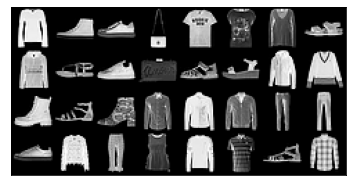

In [ ]:
show_batch(sf_batch[0:32])

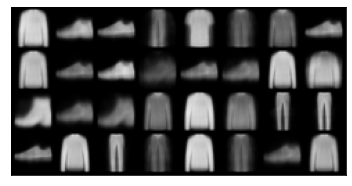

In [ ]:
show_batch(rec_batch[0:32])